# Opgave 4

In [1]:
# First, import the modules you want to use:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
from probfit import BinnedLH, Chi2Regression, Extended, UnbinnedLH # Helper tool for fitting
import sys
import scipy
from scipy import stats
from scipy.special import erfc
from scipy.stats import binom, poisson, norm

In [2]:
sys.path.append('../External_Functions')
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

In [3]:
def get_bincenter_and_counts_in_range(hist, xmin=None, xmax=None):
    
    if xmin is None:
        xmin = np.min(hist)
    if xmax is None:
        xmax = np.max(hist)
    
    counts, bin_edges, _ = hist
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    mask1 = (xmin < bin_centers) & (bin_centers <= xmax) 
    mask2 = counts > 0
    mask_final = mask1 & mask2
    return bin_centers[mask_final], counts[mask_final], np.sqrt(counts[mask_final])

def calculate_chi2(function, x_values, y_values, sy_values, *fitparameters):
    # traditional loop-version
    chi2_val = 0
    entries = 0
    for x, y, sy in zip(x_values, y_values, sy_values):
        if y > 0:
            f = function(x, *fitparameters) # calc the model value
            residual  = ( y-f ) / sy  # find the uncertainty-weighted residual
            chi2_val += residual**2  # the chi2-value is the squared residual
            entries += 1 # count the bin as non-empty since sy>0 (and thus y>0)
    
    # numpy version
    mask = (y_values>0)
    yhat = function(x_values, *fitparameters)
    chi2_val = np.sum( (y_values[mask]-yhat[mask])**2/sy_values[mask]**2)
    entries = sum(mask)
            
    return chi2_val, entries

# Define your PDF / model 
def gauss_pdf(x, mu, sigma):
    """Normalized Gaussian"""
    return 1 / np.sqrt(2 * np.pi) / sigma * np.exp(-(x - mu) ** 2 / 2. / sigma ** 2)


def gauss_extended(x, N, mu, sigma) :
    """Non-normalized Gaussian"""
    return N * gauss_pdf(x, mu, sigma)

def QND(f_ax, f_x, f_y, f_min=0, f_max=1, f_title='the title', f_ylabel='y-label', f_xlabel='x_label'):
    t_hist = f_ax.hist(f_y, bins=40, range=(f_min, f_max), histtype='step', label='Binned Data')#, weights=1/new_eL30cm)
    f_ax.set(xlabel=f_xlabel, ylabel=f_ylabel, title=f_title)
    t_x, t_y, t_sy = get_bincenter_and_counts_in_range(t_hist, f_min, f_max)
    t_binwidth = t_x[1] - t_x[0]
    t_chi2 = Chi2Regression(gauss_extended, t_x, t_y, t_sy) 
    t_minuit = Minuit(t_chi2, pedantic=False, N=f_y.sum()*t_binwidth, mu=f_y.mean(), sigma=f_y.std(ddof=1), print_level=0) 
    t_minuit.migrad();
    t_fit_N, t_fit_mu, t_fit_sigma = t_minuit.args 
    t_xaxis = np.linspace(min(f_y), max(f_y), 10000)
    t_yaxis = gauss_extended(t_xaxis, *t_minuit.args)
    t_chi2, t_entries = calculate_chi2(gauss_extended, t_x, t_y, t_sy, *t_minuit.args)
    t_NDOF = t_entries - len(t_minuit.args)
    t_chi2_prob =  stats.chi2.sf(t_chi2, t_NDOF) 
    f_ax.plot(t_xaxis, t_yaxis, '-', label='Fit')
    f_ax.set_xlim([min(f_y)-0.5,max(f_y)+0.5])
    d = {'Entries': len(f_y),'Mean': f_y.mean(),'Std': f_y.std(ddof=1),'Chi2': t_chi2,'ndf': t_NDOF, 'Prob': t_chi2_prob,}
    for name in t_minuit.parameters:
        d[name] = [t_minuit.values[name], t_minuit.errors[name]]
    text = nice_string_output(d, extra_spacing=2, decimals=4)
    add_text_to_ax(0.02, 0.95, text, f_ax, fontsize=12)
    f_ax.legend()
    
def area_under_ROC(tres, fres):
    total = 0
    for val in range(len(tres)-1):
        binwidth = fres[val] - fres[val+1]
        total += tres[val]*binwidth
    return total

## Calculate ROC curve from two histograms:

def calc_ROC(hist1, hist2):
    
    # hist1 is signal, hist2 is background
    
    # first we extract the entries (y values) and the edges of the histograms
    y_sig, x_sig_edges, _ = hist1 
    y_bkg, x_bkg_edges, _ = hist2
    
    # Check that the two histograms have the same x edges:
    if np.array_equal(x_sig_edges, x_bkg_edges):
        
        # extract the center positions (x values) of the bins (doesn't matter if we use signal or background because they are equal)
        x_centers = 0.5*(x_sig_edges[1:] + x_sig_edges[:-1])
        
        # calculate the integral (sum) of the signal and background
        integral_sig = y_sig.sum()
        integral_bkg = y_bkg.sum()
    
        # initialize empty arrays for the True Positive Rate (TPR) and the False Positive Rate (FPR).
        TPR = np.zeros_like(y_sig) # True positive rate (sensitivity)
        FPR = np.zeros_like(y_sig) # False positive rate ()
        
        # loop over all bins (x_centers) of the histograms and calculate TN, FP, FN, TP, FPR, and TPR for each bin
        for i, x in enumerate(x_centers): 
            
            # the cut mask
            cut = (x_centers < x)
            
            # true positive
            TP = np.sum(y_sig[~cut]) / integral_sig    # True positives
            FN = np.sum(y_sig[cut]) / integral_sig     # False negatives
            TPR[i] = TP / (TP + FN)                    # True positive rate
            
            # true negative
            TN = np.sum(y_bkg[cut]) / integral_bkg      # True negatives (background)
            FP = np.sum(y_bkg[~cut]) / integral_bkg     # False positives
            FPR[i] = FP / (FP + TN)                     # False positive rate            
            
        return FPR, TPR
    
    else:
        AssertionError("Signal and Background histograms have different bins and ranges")


## 4.1.1

In [4]:
# DayInYear: 1st of January=1, 2nd of January=2, ...
# DayOfWeek: Monday=0, Tuesday=1, Wednesday=2, Thursday=3, Friday=4, Saturday=5, Sunday=6
# UScoast: Non-coast=0, WestCoast=1, EastCoast=2

import numpy as np

verbose = True
N_verbose = 30
filename = 'data_UfoSightings.txt'

date = []
HourInDay = []
DayInYear = []
DayOfWeek = []
USstate = []
UScoast = []
Shape = []
DurationInSec = []


with open(filename, 'r' ) as infile:
    header1 = infile.readline()     # Read (and ignore) the first four line, which are header lines!
    header2 = infile.readline()
    header3 = infile.readline()
    header4 = infile.readline()
    if verbose:
        print('Date            HourInDay       DayInYear       DayOfWeek       USstate         UScoast         Shape           DurationInSec')
        
    counter = 0
    for line in infile:
        
        columns = line.strip().split()
        if (len(columns) == 8):
            
            date.append(columns[0])
            HourInDay.append(float(columns[1]))
            DayInYear.append(int(columns[2]))
            DayOfWeek.append(int(columns[3]))
            USstate.append(columns[4])
            UScoast.append(int(float(columns[5])))
            Shape.append(columns[6])
            DurationInSec.append(float(columns[7]))
            
            counter += 1
            
            if verbose and counter < N_verbose:
                print(f"""{date[-1]} \t{HourInDay[-1]:.1f} \t\t{DayInYear[-1]} \t\t{DayOfWeek[-1]} \t\t{USstate[-1]} \t\t{UScoast[-1]} \t\t{Shape[-1]:10s} \t{DurationInSec[-1]}""")

print(f"The total number of data points read is: {counter:d}")


date = np.array(date)
HourInDay = np.array(HourInDay)
DayInYear = np.array(DayInYear)
DayOfWeek = np.array(DayOfWeek)
USstate = np.array(USstate)
UScoast = np.array(UScoast)
Shape = np.array(Shape)
DurationInSec = np.array(DurationInSec)
DurationInSec = np.sort(DurationInSec)

Date            HourInDay       DayInYear       DayOfWeek       USstate         UScoast         Shape           DurationInSec
1/4/2019 	0.2 		4 		4 		MO 		0 		Rectangle  	20.0
1/3/2019 	20.5 		3 		3 		TN 		0 		Disk       	1.0
1/3/2019 	20.0 		3 		3 		IL 		0 		Triangle   	20.0
1/3/2019 	17.3 		3 		3 		MA 		2 		Diamond    	120.0
1/3/2019 	15.0 		3 		3 		CA 		1 		Oval       	1800.0
1/3/2019 	6.0 		3 		3 		ND 		0 		Light      	30.0
1/3/2019 	4.6 		3 		3 		CA 		1 		Circle     	1200.0
1/3/2019 	2.8 		3 		3 		AZ 		0 		Unknown    	300.0
1/1/2019 	0.4 		1 		1 		ID 		0 		Light      	180.0
1/1/2019 	0.1 		1 		1 		FL 		2 		Circle     	180.0
12/31/2018 	23.0 		365 		0 		FL 		2 		Light      	300.0
12/31/2018 	21.8 		365 		0 		MS 		0 		Unknown    	300.0
12/31/2018 	21.8 		365 		0 		SC 		2 		Sphere     	10.0
12/31/2018 	21.7 		365 		0 		FL 		2 		Fireball   	20.0
12/31/2018 	20.2 		365 		0 		CT 		2 		Circle     	20.0
12/31/2018 	19.5 		365 		0 		FL 		2 		Unknown    	600.0
12/31/2018 	6.8 		365 		0 		CA

In [5]:
print(DurationInSec)
bob = DurationInSec

[0.00e+00 1.00e+00 1.00e+00 ... 4.32e+04 5.04e+04 6.48e+04]


In [6]:
print(len(DurationInSec))

64719


In [7]:
#DurationInSec = DurationInSec[DurationInSec < 10000]

64800.0


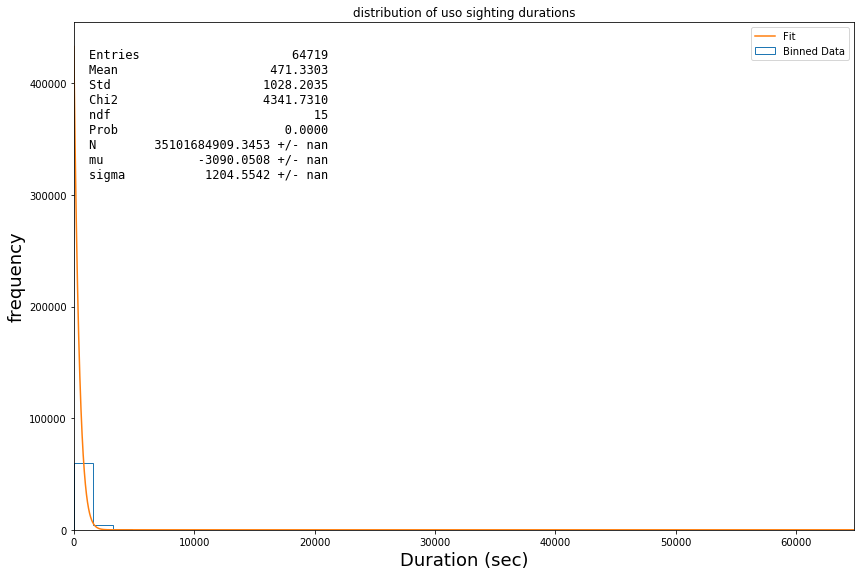

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))        
#ax.hist(DurationInSec, bins=100, range=(min(DurationInSec), max(DurationInSec)), histtype='step')
#ymax = ax.get_ylim()[1]*1.2
ax.set(title='title', xlim=(min(DurationInSec)-1, max(DurationInSec)+1))

y = DurationInSec
x = np.linspace(min(DurationInSec), max(DurationInSec), len(DurationInSec))

QND(ax, x, y, f_min=min(y), f_max=max(y), f_title='distribution of uso sighting durations', f_ylabel='frequency', f_xlabel='time (sec)')

print(max(DurationInSec))
fig.tight_layout()
ax.set_xlabel("Duration (sec)", fontsize=18)
ax.set_ylabel('frequency', fontsize=18)
#fig.savefig('4_1_1.pdf', dpi=300)

In [9]:
dur_mean = np.mean(DurationInSec)
dur_std = np.std(DurationInSec)/np.sqrt(len(DurationInSec))
print(f"Mean: {dur_mean:.5f} and std: {dur_std:.5f}, which is exactly the same as my gaussian when diving its std with sqrt(n) ")
print(f"The median is: {DurationInSec[int(len(DurationInSec)/2)]:.3f}")

Mean: 471.33034 and std: 4.04166, which is exactly the same as my gaussian when diving its std with sqrt(n) 
The median is: 180.000


## 4.1.2 

In [10]:
dur_east = DurationInSec[UScoast == 2]
dur_west = DurationInSec[UScoast == 1]

Westcoast mean: 488.38984+/-7.98818 and eastcoast mean: 434.30553+/-7.42475


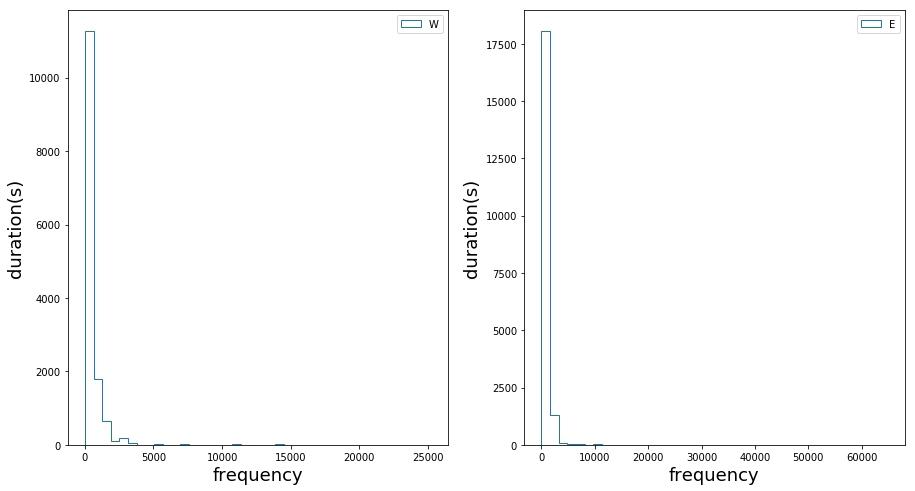

In [26]:
dur_fit, dur_ax = plt.subplots(ncols = 2, figsize=(15,8))
ax_w, ax_e = dur_ax
ax_w.hist(dur_west, bins=40, histtype='step')
ax_e.hist(dur_east, bins=40, histtype='step')

e_mean = np.mean(dur_east)
e_std = np.std(dur_east)/np.sqrt(len(dur_east))
w_mean = np.mean(dur_west)
w_std = np.std(dur_west)/np.sqrt(len(dur_west))
print(f"Westcoast mean: {w_mean:.5f}+/-{w_std:.5f} and eastcoast mean: {e_mean:.5f}+/-{e_std:.5f}")

ax_w.set_xlabel("frequency", fontsize=18)
ax_w.set_ylabel('duration(s)', fontsize=18)
ax_w.legend('West coast observations')

ax_e.set_xlabel("frequency", fontsize=18)
ax_e.set_ylabel('duration(s)', fontsize=18)
ax_e.legend('East coast observations')
"one"
#dur_fit.savefig('4_1_2.pdf')

In [12]:
bob_e = DurationInSec[UScoast == 2]
bob_w = DurationInSec[UScoast == 1]
kolmogorov= stats.ks_2samp(bob_e,bob_w)
kolmogorov

Ks_2sampResult(statistic=0.10544196455469823, pvalue=6.6251796678672565e-80)

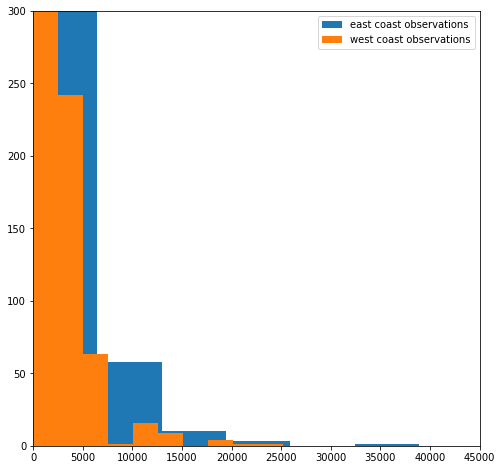

In [27]:
ang, fis = plt.subplots(figsize=(8,8))
fis.hist(dur_east, label='east coast observations')
fis.hist(dur_west, label='west coast observations')
fis.set_xlim(0,45000)
fis.set_ylim(0,300)
fis.legend()
#ang.savefig('4_1_2_.pdf')

In [17]:
def pos_pdf(x, lam):
    return (lam**x*np.exp(-lam)) / scipy.special.factorial(x)

In [18]:
def func_poisson(x, N, mu) :
    return N * poisson.pmf(x, mu)

Calculate a poissonian fit

In [19]:
x = np.linspace(0, 65000, 65000)
home_chi2_poisson = Chi2Regression(func_poisson, x, dur_east, np.sqrt(dur_east))
home_minuit_poisson = Minuit(home_chi2_poisson, pedantic=False, N=len(dur_east), mu=e_mean, print_level = 0) #   
home_minuit_poisson.migrad();  # perform the actual fit
home_Ndof_poi = len(x) - 2     # 2 parameters in fit
home_Prob_poi = stats.chi2.sf(home_minuit_poisson.fval, home_Ndof_poi)

#away_results = away_results[away_results>0]
away_chi2_poisson = Chi2Regression(func_poisson, x, dur_west, np.sqrt(dur_west))
away_minuit_poisson = Minuit(away_chi2_poisson, pedantic=False, N=len(dur_west), mu=w_mean, print_level = 0) #   
away_minuit_poisson.migrad();  # perform the actual fit
away_Ndof_poi = len(x) - 2     # 2 parameters in fit
away_Prob_poi = stats.chi2.sf(away_minuit_poisson.fval, away_Ndof_poi)

xaxis = np.linspace(-0.5, 9+0.5, 1000)                  # This way we include all possibilties!
#yaxis = func_poisson(np.floor(xaxis+0.5), *minuit_poisson.args)
home_fit = func_poisson(np.floor(xaxis+0.5), *home_minuit_poisson.args)
away_fit = func_poisson(np.floor(xaxis+0.5), *away_minuit_poisson.args)
ax1.plot(xaxis, home_fit, 'b-', label=f'Poisson fit(home)  p(Chi2={home_minuit_poisson.fval:.1f},Ndof={home_Ndof_poi:d}) = {home_Prob_poi:.3f}')
ax2.plot(xaxis, away_fit, 'r-', label=f'Poisson fit(away)  p(Chi2={away_minuit_poisson.fval:.1f},Ndof={away_Ndof_poi:d}) = {away_Prob_poi:.3f}')
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
fig.savefig('football.pdf', dpi=300)
fig



RuntimeError: exception was raised in user function
User function arguments:
     N = +19569.000000
    mu = +434.305534
Original python exception in user function:
IndexError: Out of bounds on buffer access (axis 0)
  File "probfit/costfunc.pyx", line 636, in probfit.costfunc.Chi2Regression.__call__
  File "probfit/_libstat.pyx", line 200, in probfit._libstat.compute_chi2_f


Its incrediable difficult to say anything about their distributions when they are so hard to pin point, additionally they contain so many values in the low regime, yet still some in the high so culling values or increasin bin amount doesn't really do anything nice for the fits.
Also is appears that a poissonian fit(expected PDF) cannot be made on it because the numbers are so extreme.

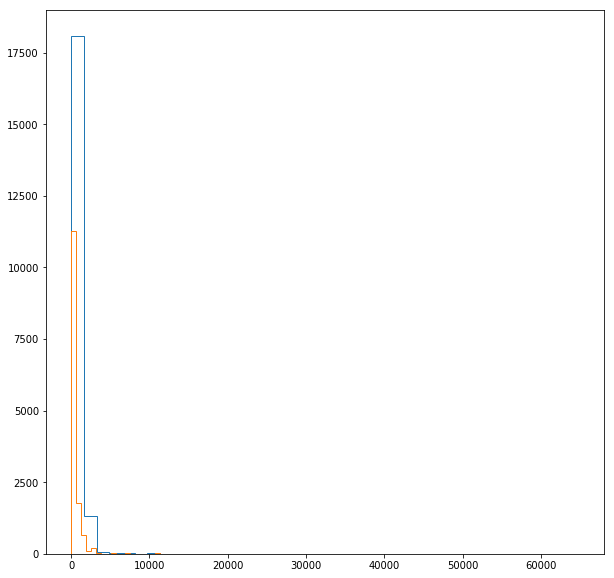

In [33]:
fishfig, fish_ax = plt.subplots(figsize=(10,10))
finalmen = fish_ax.hist(dur_east, bins=40, histtype='step', label='men')
finalwomen = fish_ax.hist(dur_west, bins=40, histtype='step', label='women')

<class 'tuple'> <class 'tuple'>


TypeError: 'NoneType' object is not iterable

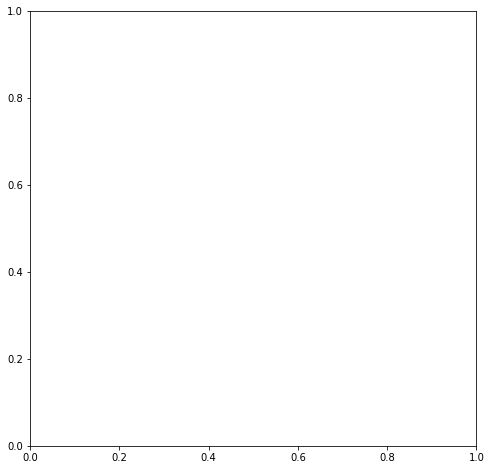

In [37]:
fig2, ax2 = plt.subplots(figsize=(8, 8))

# calculate FPR and TPR by calc_ROC:
#FPR, TPR = calc_ROC(finalmen, finalwomen)
print(type(finalmen), type(finalwomen))
FPR, TPR = calc_ROC(finalmen, finalwomen)

# plot the roc-curve:
ax2.plot(FPR, TPR, '-', label='text_sigma')

# add text
#ax2.text(text_sigma_loc[i][0], text_sigma_loc[i][1], text_sigma, size=12, verticalalignment='center', transform=ax2.transAxes)


# plot diagonal line
ax2.plot([0, 1], [0, 1], '--', label='Random Guess')

# set figure options:
ax2.set(xlabel='False Positive Rate (Background Efficiency)', ylabel='True Positive Rate (Signal Efficiency)', xlim=(0, 1), ylim=(0, 1))
ax2.legend()

fig2.tight_layout()
#fig2

## 4.1.3

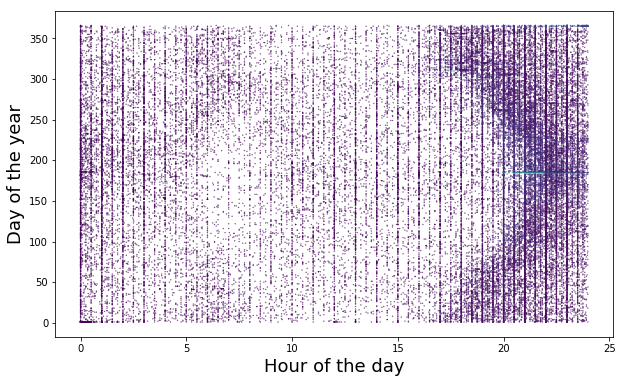

In [35]:
myfig, myax = plt.subplots(figsize=(10,6))
xedges, yedges = np.linspace(0, 24, 24), np.linspace(0, 365, 365)
hist, xedges, yedges = np.histogram2d(HourInDay, DayInYear, (xedges, yedges))
xidx = np.clip(np.digitize(HourInDay, xedges), 0, hist.shape[0]-1)
yidx = np.clip(np.digitize(DayInYear, yedges), 0, hist.shape[1]-1)
c = hist[xidx, yidx]
myax.scatter(HourInDay, DayInYear, c=c, s=0.1)
myax.set_xlabel("Hour of the day", fontsize=18)
myax.set_ylabel('Day of the year', fontsize=18)
#myax.legend(["Density plot of observations during each day and hour of the year"], fontsize=14)

myfig.savefig('4_1_3.png', pdf=300)
#plt.show()

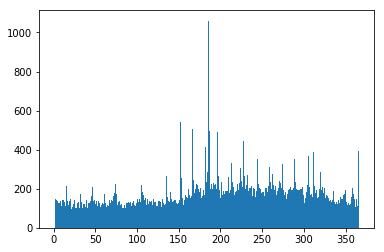

In [36]:
new_list = np.sort(DayInYear)
plt.hist(DayInYear, bins=365)
counts, _ = np.histogram(DayInYear, bins=365)
counts[184]
plt.savefig('3_4_bah.pdf')

1

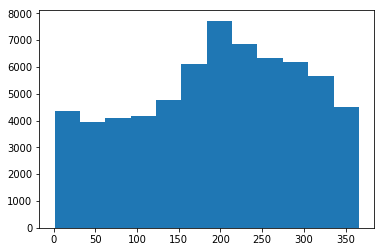

In [62]:
plt.hist(DayInYear, bins=12)
1

1

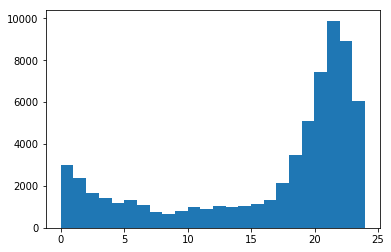

In [63]:
plt.hist(HourInDay, bins=24)
1

As we can see its pretty clear that there is a trend for observations in the "dark" hours, which a longer period during the winter since the sun is down for a longer period. 
In addition to this, there is a slight increase (vs the rest of the day) in observations during the morning "twilight" around 6-7 in the winter and 4-5 in the summer, probably because thats where some people get up, and are able to stop them.

In [45]:
men = HourInDay
women = DayInYear

def var(x, y):
    N = len(x)
    return 1/N * np.sum( (x-np.mean(x)) * (y-np.mean(y)) ) 

def cor_eff(v, x, y):
    return v / (np.std(x) * (np.std(y)))


men_cor = cor_eff(var(men, women), men, women)
#women_cor = cor_eff(var(women[0], women[1]), women[0], women[1])
#both_cor = cor_eff(var(lst_loud, lst_aud), lst_loud, lst_aud)

print(men_cor)
#print(women_cor)
#print(both_cor)

0.024025433339388128


In [113]:
def hisogrammo(x, nbin):
    counts, bin_edges = np.histogram(x, bins=nbin)
    bin_centers = (bin_edges[1:] + bin_edges[:-1])*0.5
    return counts, bin_centers, 1

## 4.1.4

In [38]:
obs_day = np.array(DayOfWeek[UScoast==1])
obs_short = np.array(obs_day[obs_day < 4])

1

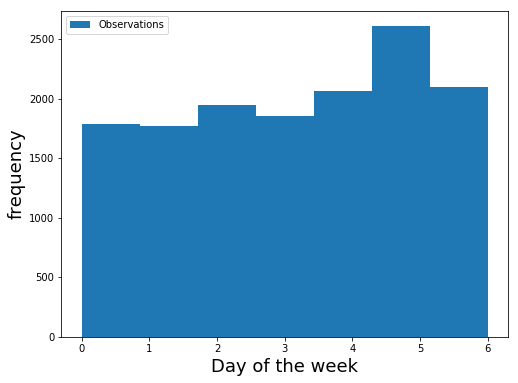

In [43]:
figgy, axxi = plt.subplots(figsize=(8,6))
axxi.hist(obs_day, bins=7)
axxi.set_xlabel("Day of the week", fontsize=18)
axxi.set_ylabel('frequency', fontsize=18)
axxi.legend(["Observations"])
#figgy.savefig('4_1_4.pdf')
1

In [90]:
obs_mean = np.mean(obs_day)
obs_std = np.std(obs_day)/np.sqrt(len(obs_day))
print(f"Observation mean: {obs_mean:.3f}+/-{obs_std:.3f}")

Observation mean: 3.192+/-0.017


In [126]:
def fitten(x, y):
    return x*0 + y

In [127]:
x = np.linspace(0,6,7) #bin_centers[counts>0]
y = obs_day #counts[counts>0]
home_err = np.sqrt(y)
sy = np.sqrt(y) #s_counts[counts>0]

In [131]:
home_chi2_poisson = Chi2Regression(fitten, x, y, sy)
home_minuit_poisson = Minuit(home_chi2_poisson, pedantic=False, y=2, print_level = 1) #   
home_minuit_poisson.migrad();  # perform the actual fit
home_Ndof_poi = len(x) - 1     # 2 parameters in fit
home_Prob_poi = stats.chi2.sf(home_minuit_poisson.fval, home_Ndof_poi)

RuntimeError: exception was raised in user function
User function arguments:
    y = +2.000000
Original python exception in user function:
ValueError: error contains value too small or negative
  File "probfit/costfunc.pyx", line 636, in probfit.costfunc.Chi2Regression.__call__
  File "probfit/_libstat.pyx", line 204, in probfit._libstat.compute_chi2_f


Expected mean would be 3.5, so given this we have a distance of ~11.29 sigmas - quite far. We are however also gonna line a flat function and see how much it differs from this

1

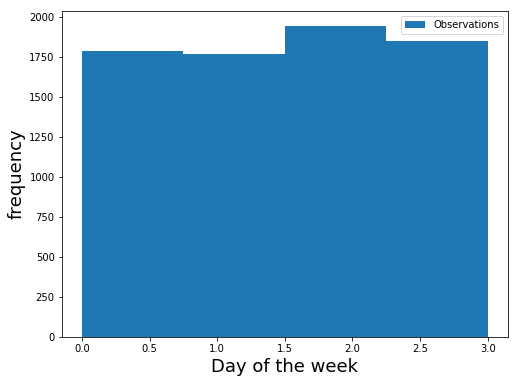

In [47]:

fib, ab = plt.subplots(figsize=(8,6))
ab.hist(obs_short, bins=4)
ab.set_xlabel("Day of the week", fontsize=18)
ab.set_ylabel('frequency', fontsize=18)
ab.legend(["Observations"])
#fib.savefig('4_1_4_.pdf')
1

In [132]:
short_mean = np.mean(obs_short)
short_std = np.std(obs_short)/np.sqrt(len(obs_short))
print(f"Observation mean: {short_mean:.3f}+/-{short_std:.3f}")

Observation mean: 1.524+/-0.013


Here the difference is 1.8 sigmas, or very nice